In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# <font color='blus'>1. Breeds classification using pre-trained VGG16 model</font>
`VGG16` is a CNN network provided by / implemented in `Keras` with 16 layers.
<br>

While convolutional layers are used for features extraction, fully connected layers are used for classification.
<br>

Those 2 set of layers are used here to classify images as breeds, since breeds have already been learned by network.



In [ ]:
import P7_DataBreed
if False :
    oP7_DataBreed = P7_DataBreed.update_object_save(oP7_DataBreed, is_saved=False,is_new_attribute=True)
    oP7_DataBreed.show()


#### Object containing data breed model is loaded from dumped file.

A sample is created from dumped object.

In [ ]:
import p5_util
import P7_DataBreed
if True :
    oP7_DataBreed_sample = p5_util.object_load('./data/oP7_DataBreed.dump')
    oP7_DataBreed_sample.show()
    oP7_DataBreed_sample.breed_show()
else : 
    oP7_DataBreed = P7_DataBreed.P7_DataBreed('./data/Images')
    oP7_DataBreed.show()
    

Breeds list for evaluation is fixed.

In [ ]:
list_dirbreed = ['n02107142-Doberman','n02115641-dingo','n02113978-Mexican_hairless']

oP7_DataBreed_sample.load(list_dirbreed=['n02107142-Doberman','n02115641-dingo','n02113978-Mexican_hairless'])
oP7_DataBreed_sample.show()

In [ ]:
test_size = 0.15
resize = (224,224)
square=None

X_train, X_test, y_train, y_test, nClass = oP7_DataBreed_sample.keras_image_train_test(test_size = 0.3, resize=resize)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, nClass)


#### Resources for dataset computation are released.

In [ ]:
del(oP7_DataBreed_sample)
oP7_DataBreed_sample=None

#### Keras dataset is saved

In [ ]:
import p5_util
filename = './data/dict_keras_dataset.dump'
list_dirbreed = ['n02107142-Doberman','n02115641-dingo','n02113978-Mexican_hairless']
dict_keras_dataset = {'description':list_dirbreed,'payload':(X_train, X_test, y_train, y_test, nClass)}
p5_util.object_dump(dict_keras_dataset, filename)

#### Transfer learning from pre-trained VGG16 over imagenet

`VGG16` trained model from `imagenet` is downloaded without classification layer.


In [2]:
from keras.applications import VGG16
 
vgg16_pretrained_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


vgg16_pretrained_conv.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

vgg16_imagenet_pretrained = models.Sequential()
vgg16_imagenet_pretrained.add(vgg16_pretrained_conv)
vgg16_imagenet_pretrained.add(layers.Flatten())

#--------------------------------------------------------------------------
# Get output dimensions from convolutional layer
#--------------------------------------------------------------------------
conv_layer_output_shape = np.prod(vgg16_imagenet_pretrained.output_shape[1:])
conv_layer_output_shape

#--------------------------------------------------------------------------
# Fist dense layer is compliant with output of last convolutional layer 
# from pre-trained model for transfer learning
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(512, activation='relu', input_dim=conv_layer_output_shape))
vgg16_imagenet_pretrained.add(layers.Dropout(0.5))
#--------------------------------------------------------------------------
# Last dense layer will classify amont nClass classes.
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(nClass, activation='softmax'))
if False :
    vgg16_imagenet_pretrained.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    vgg16_imagenet_pretrained.summary()

#### Full connected layers are added

* Input dimension matches with output dim from last convolutional layer
* Output dimension matches with number of classes

#### Model is compiled

In [6]:
vgg16_imagenet_pretrained.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001\
                                                             , momentum=0.9), metrics=["accuracy"])
vgg16_imagenet_pretrained.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________


#### Pre-trained model is saved

In [ ]:
import p5_util
filename = './data/vgg16_imagenet_pretrained.dump'
p5_util.object_dump(vgg16_imagenet_pretrained, filename)

#### Keras dataset is loaded

In [3]:
import p5_util

filename = './data/dict_keras_dataset.dump'
dict_keras_dataset = p5_util.object_load(filename)
(X_train, X_test, y_train, y_test, nClass) = dict_keras_dataset['payload']

p5_util.object_load : fileName= ./data/dict_keras_dataset.dump


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((322, 224, 224, 3), (139, 224, 224, 3), (322, 3), (139, 3))

#### Pre-trained model is loaded

In [ ]:
import p5_util
filename = './data/vgg16_imagenet_pretrained.dump'
vgg16_imagenet_pretrained = p5_util.object_load(filename)

In [7]:
batch_size=100
history = vgg16_imagenet_pretrained.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

Train on 322 samples, validate on 139 samples
Epoch 1/100
322/322 [==============================] - 125s 388ms/step - loss: 1.3868 - acc: 0.3292 - val_loss: 1.1156 - val_acc: 0.3885
Epoch 2/100
322/322 [==============================] - 127s 395ms/step - loss: 1.2630 - acc: 0.3789 - val_loss: 1.1184 - val_acc: 0.4029
Epoch 3/100
322/322 [==============================] - 125s 390ms/step - loss: 1.2265 - acc: 0.3665 - val_loss: 1.0378 - val_acc: 0.5108
Epoch 4/100
322/322 [==============================] - 125s 388ms/step - loss: 1.1454 - acc: 0.4503 - val_loss: 1.0141 - val_acc: 0.5324
Epoch 5/100
322/322 [==============================] - 125s 389ms/step - loss: 1.0674 - acc: 0.4783 - val_loss: 1.0138 - val_acc: 0.4460
Epoch 6/100
322/322 [==============================] - 126s 393ms/step - loss: 0.9626 - acc: 0.5466 - val_loss: 0.9936 - val_acc: 0.4604
Epoch 7/100
322/322 [==============================] - 113s 350ms/step - loss: 0.9651 - acc: 0.5435 - val_loss: 0.9485 - val_acc: 0.

139/139 [==============================] - 15s 106ms/step
Evaluation result on Test Data : Loss = 0.67, accuracy = 0.78


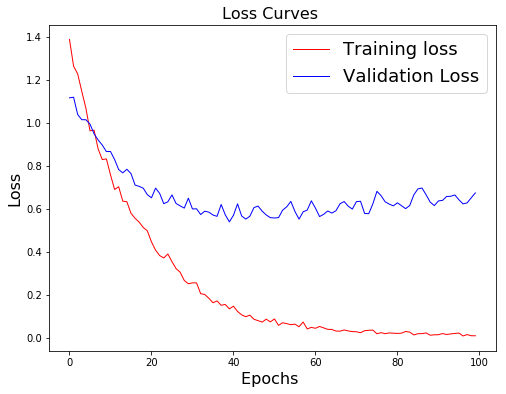

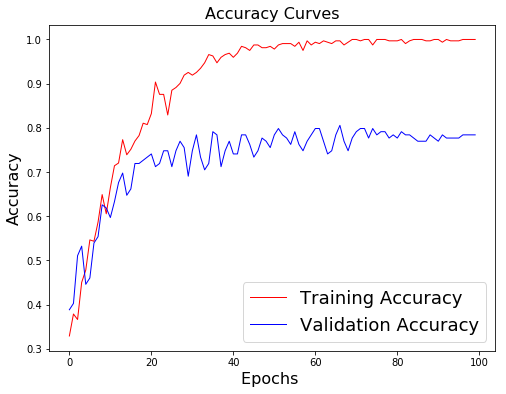

In [9]:
import p7_util

lost, score_acc = p7_util.p7_plot_cnn_history(vgg16_imagenet_pretrained, X_test, y_test, history=history)

Results show that new images can't be classified with as much accuracy then trained images.
<br>

Also, loss function do not decrease for tested images as it does for trained images. This is the sign network overfit.
<br>

In [10]:
import p5_util
filename = './data/transfer_learning_'+str(nClass)+'_breeds.dump'
p5_util.object_dump(vgg16_imagenet_pretrained, filename)

#### Reloading transfer learned network

In [ ]:
import p5_util
filename = './data/transfer_learning_3_breeds.dump'
vgg16_imagenet_pretrained = p5_util.object_load(filename)

In [ ]:
import p7_util

lost, score_acc = p7_util.p7_plot_cnn_history(vgg16_imagenet_pretrained, X_test, y_test, history=None)

#### Continue to train ...

In [ ]:
batch_size=100
history = vgg16_imagenet_pretrained.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

In [ ]:
import p7_util

lost, score_acc = p7_util.p7_plot_cnn_history(vgg16_imagenet_pretrained, X_test, y_test, history=history)

# <font color='blus'>2. Breeds classification using pre-trained VGG16 model</font>
`VGG16` is a CNN network provided by / implemented in `Keras` with 16 layers.
<br>

While convolutional layers are used for features extraction, fully connected layers are used for classification.
<br>

Those 2 set of layers are used here to classify images as breeds, since breeds have already been learned by network.



In [ ]:
type(vgg16_pretrained)

#### A breed and an image is selected and displayed

In [ ]:
oP7_DataBreed.breed_show()

List of images files names from selected breed is displayed.

In [ ]:
import P7_DataBreed

oP7_DataBreed.show_image_name('Mexican_hairless')

A selected PIL image is displayed

In [ ]:
import cv2

import p3_util
import p3_util_plot


import P7_DataBreed
import p7_util

breedname= 'Doberman'
imagename= 'n02107142_16400.jpg'
imagename= 'n02107142_4314.jpg'
dirbreed = 'n02107142-Doberman'

oP7_DataBreed_single = P7_DataBreed.P7_DataBreed()
oP7_DataBreed_single._dict_breed_sample=oP7_DataBreed._dict_breed_sample.copy()

list_restricted_image = [(breedname,[imagename])]
oP7_DataBreed_single.list_restricted_image = list_restricted_image

oP7_DataBreed_single.load(dirbreed=dirbreed, imagename=imagename)

p7_util.p7_image_pil_show(oP7_DataBreed_single._dict_img_pil,std_image_size=(500,375), is_title=False)

Selected image is pre-processed in order to feed pre-trained VGG16 network.

Prediction returns `y_pred`, a 1000 sized vector.
<br>

Built-in function `decode_predictions` allows to provide human readable results.

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16
import p3_util_plot

image_pathname = oP7_DataBreed._build_pathname(dirbreed,imagename)

# Charger l'image PIL
pil_image = load_img(image_pathname, target_size=(224, 224))  

# Convertir en tableau numpy
arr_image = img_to_array(pil_image)  

# Créer la collection d'images (un seul échantillon)
sample_count=1
arr_image = arr_image.reshape((sample_count, arr_image.shape[0], arr_image.shape[1], arr_image.shape[2]))  

# Prétraiter l'image comme le veut VGG-16
X_test = vgg16.preprocess_input(arr_image)  

# Predict image breed thanks to VGG16 pre-trained model
y_pred = vgg16_pretrained.predict(X_test)

#### Top prediction results are displayed.


In [ ]:
# Afficher les 3 classes les plus probables
top_results = 3
print("***Breed predictions top "+str(top_results)+" results")
[p3_util_plot.printmd(my_tuple) for my_tuple in vgg16.decode_predictions(y_pred, top=top_results)[0]]

# <font color='blus'> 3. Transfer Learning using `VGG16` pre-trained model</font>

Pre-trained  `VGG16` model is used as a feature extractor.
<br>

It as learned discriminative features. Layers used for feature extraction are freezed.

We consider we've a few sample to be trained  (3 breeds and close to 120 images) from Standford Dogs dataset. 
<br>

We expect to benefit features extraction from already trained model over imagenet images bank.

<br>
Transfer learning seems to be a proper strategy to achieve classification over a few number of samples.


#### Keras dataset is loaded

In [10]:
import p5_util

filename = './data/dict_keras_dataset.dump'
dict_keras_dataset = p5_util.object_load(filename)
(X_train, X_test, y_train, y_test, nClass) = dict_keras_dataset['payload']

p5_util.object_load : fileName= ./data/dict_keras_dataset.dump


In [14]:
print(dict_keras_dataset['description'])

['n02107142-Doberman', 'n02115641-dingo', 'n02113978-Mexican_hairless']


#### Download a VGG16 model that has been pre-trained with imageNet  : 
* Last fully connected layers are removed; in the resulting model only convolutional layers stay.
* Image reshape is enforced to (224,224,3)

In [3]:
from keras.applications import VGG16
 
vgg16_pretrained_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


vgg16_pretrained_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### Convolutional layers are frozen

In [4]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in vgg16_pretrained_conv.layers:
    layer.trainable = False

In [5]:
vgg16_pretrained_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

As it can be shown above, all parameters from convolutional layers have been rendered not trainable.

#### Classification layers are added

In [7]:
nClass=3

In [8]:
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

vgg16_imagenet_pretrained = models.Sequential()

#--------------------------------------------------------------------------
# Convolutional layers are added to the model
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(vgg16_pretrained_conv)


#--------------------------------------------------------------------------
# Flatten transformation is added in-between of output of convolutional 
# layers and of input of classification layers .
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Flatten())

#--------------------------------------------------------------------------
# Get output dimensions from convolutional layer
#--------------------------------------------------------------------------
conv_layer_output_shape = np.prod(vgg16_imagenet_pretrained.output_shape[1:])
conv_layer_output_shape

#--------------------------------------------------------------------------
# Fist dense layer is compliant with output of last convolutional layer 
# from pre-trained model for transfer learning
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(512, activation='relu', input_dim=conv_layer_output_shape))
vgg16_imagenet_pretrained.add(layers.Dropout(0.5))

#--------------------------------------------------------------------------
# Last dense layer will classify amont nClass classes.
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(nClass, activation='softmax'))


In [9]:
vgg16_imagenet_pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________


Only parameters from classification layers are able to be parametrable.

In [13]:
vgg16_imagenet_pretrained.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001\
                                                             , momentum=0.9), metrics=["accuracy"])
vgg16_imagenet_pretrained.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________


#### Model is trained with previous features extracted from convolutional layers.

In [19]:
history = vgg16_imagenet_pretrained.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=100,
                    validation_data=(X_test,y_test))


Train on 322 samples, validate on 139 samples
Epoch 1/50
322/322 [==============================] - 61s 191ms/step - loss: 0.8963 - acc: 0.5497 - val_loss: 0.9850 - val_acc: 0.5324
Epoch 2/50
322/322 [==============================] - 57s 178ms/step - loss: 0.8856 - acc: 0.5932 - val_loss: 0.9456 - val_acc: 0.5827
Epoch 3/50
322/322 [==============================] - 62s 194ms/step - loss: 0.8804 - acc: 0.5839 - val_loss: 0.9345 - val_acc: 0.5324
Epoch 4/50
322/322 [==============================] - 54s 167ms/step - loss: 0.8034 - acc: 0.6429 - val_loss: 0.9284 - val_acc: 0.5396
Epoch 5/50
322/322 [==============================] - 54s 168ms/step - loss: 0.8232 - acc: 0.6149 - val_loss: 0.9136 - val_acc: 0.5683
Epoch 6/50
322/322 [==============================] - 53s 165ms/step - loss: 0.7965 - acc: 0.6584 - val_loss: 0.9079 - val_acc: 0.6259
Epoch 7/50
322/322 [==============================] - 60s 186ms/step - loss: 0.7734 - acc: 0.6832 - val_loss: 0.8929 - val_acc: 0.6187
Epoch 8/5

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


139/139 [==============================] - 14s 101ms/step
Evaluation result on Test Data : Loss = 0.72, accuracy = 0.71


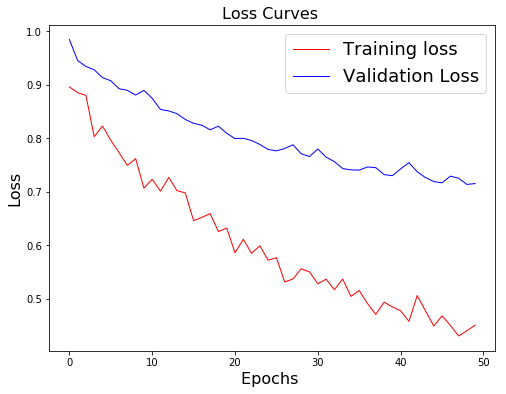

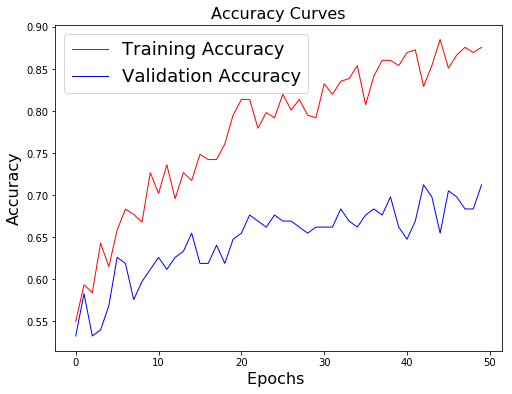

In [20]:
import p7_util

lost, score_acc = p7_util.p7_plot_cnn_history(vgg16_imagenet_pretrained, X_test, y_test, history=history)

#### Features are extracted feeding convolution layers with images issued from train directory.

* `y_train` holds encoded classes.
* `X_train` holds images used for training model.

In [ ]:
batch_id = 0
for inputs_batch, labels_batch in train_generator:
    
    print("Batch ID= "+str(batch_id))
    features_batch = vgg16_pretrained_conv.predict(inputs_batch)
    X_train[batch_id * batch_train_size : (batch_id + 1) * batch_train_size] = features_batch
    y_train[batch_id * batch_train_size : (batch_id + 1) * batch_train_size] = labels_batch
    batch_id += 1
    if batch_id * batch_train_size >= nTrain:
        break
         
X_train = np.reshape(X_train, (nTrain, 7 * 7 * 512))

In [ ]:
X_train.shape

#### Test dataset is loaded from test directory

In [ ]:
import numpy as np
from keras.preprocessing import image
batch_test_size = 20

test_dir  = './data/ImagesPretrained/test'
 
datagen = image.ImageDataGenerator(rescale=1./255)

#-----------------------------------------------------------------------------
# test_generator is capable reading images from a given directory.
#-----------------------------------------------------------------------------
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_test_size,
    class_mode='categorical',
    shuffle=False)


#### Features from Test set are extracted

In [ ]:
nTest = 101

X_test = np.zeros(shape=(nTest, 7, 7, 512))
y_test = np.zeros(shape=(nTest,nClass))
X_test.shape, y_test.shape

In [ ]:
batch_id = 0
for inputs_batch, labels_batch in test_generator:
    start = batch_id * batch_test_size
    end   = start + batch_test_size
    remain = X_test.shape[0] - start
    
    #end = min(end, remain)
    print("Batch ID= "+str(batch_id)+" : start= "+str(start)+ " end= "+str(end)+" remain= "+str(remain))
    features_batch = vgg16_pretrained_conv.predict(inputs_batch)

    if remain < batch_test_size:
        end  = start+remain
        X_test[start : end] = features_batch[:remain]
        y_test[start : end] = labels_batch[:remain]
    else :
        X_test[start : end] = features_batch
        y_test[start : end] = labels_batch
    batch_id += 1
    if batch_id * batch_test_size >= nTest:
        break

X_test = np.reshape(X_test, (nTest, 7 * 7 * 512))

In [ ]:
X_test.shape, y_test.shape

#### 2 full connected layers are created in order to complete convolutional layers.

3 classes take place in the model.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
model = models.Sequential()
# Fist dense layer is compliant with output of last convolutional layer from pre-trained model for transfer learning
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))

# Last dense layer will classify amont nClass classes.
model.add(layers.Dense(nClass, activation='softmax'))

model.summary()

In [ ]:
25088, 7*7*512

In [ ]:
import matplotlib.pyplot as plt

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves ',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=1.0)
plt.plot(history.history['val_acc'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Wrongly classified breeds

In [ ]:
fnames = test_generator.filenames
 
ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(X_test)
prob = model.predict(X_test)
 
errors = np.where(predictions != ground_truth)[0]
print("Number of errors = {}/{}".format(len(errors),nTest))

In [ ]:
from keras.preprocessing.image import load_img

for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
     
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
     
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

In [ ]:
150/600

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
import p5_util
if False :
    # Load ImageNet pre-trained model from VGG-16 
    # Option include_top=False leads to remove last Fully connected layer.
    # VGG16 model is downloaed from network.
    #vgg16_pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    vgg16_pretrained_model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    p5_util.object_dump(vgg16_pretrained_model,'./data/vgg16_pretrained_model.dump')
else :
    vgg16_pretrained_model = p5_util.object_load('./data/vgg16_pretrained_model.dump')
vgg16_pretrained_model.summary()

#### An image is selected among breeds

In [ ]:
oP7_DataBreed.breed_show()

In [ ]:
breedname='dingo'

In [ ]:
oP7_DataBreed.show_image_name(breedname, is_sample_show=False)

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import vgg16
import p7_util

imagename = 'n02115641_4970.jpg'
pil_image = oP7_DataBreed.read_image(breedname, imagename)

keras_image = p7_util.p7_pil_to_keras_image(pil_image, is_show=True)
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(keras_image.copy())
 
# get the predicted probabilities for each class
predictions = vgg16_pretrained_model.predict(processed_image)
# print predictions
 
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
pred_breedname_result = decode_predictions(predictions)
pred_breedname = pred_breedname_result[0][0][1]
pred_proba = pred_breedname_result[0][0][2]*100
print("Original breed name = "+breedname+" / Greatest likehood breed name= "+str(pred_breedname)+" Prob={0:0.2F}".format(pred_proba))

#### Transfer learning model is built
* Output of all layers previous top layer are extracted.
* A new fully connected layer (dense layer) is built using previous layer as an input layer

In [ ]:
from keras import models
from keras import layers

# Outputs parameters are retrieved from previous layers
vgg16_model_tensor = vgg16_pretrained_model.output

# A new fully connected layer is then added in order to classify nbreeds breeds.
# Activation function is Softmax; This last layer is applied to the data input vgg16_model_parameters
vgg16_fc_tensor = layers.Dense(nbreed, activation='softmax')(vgg16_model_tensor)

# New VGG16 model for transfer learning is defined with : 
# * All layers except last layer are issued from 
# * fully connected layer previously defined.
model_vgg16_transfer_learning = models.Model(inputs=vgg16_pretrained_model.input, outputs=vgg16_fc_tensor)
type(model_vgg16_transfer_learning)

#### Compilation : shape of all internal layers are computed by compiler

In [ ]:
# Compiler le modèle 
from keras import optimizers

model_vgg16_transfer_learning.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
import numpy as np
import p5_util

filename='./data/arr_keras_X_y_train_test.dump'
(X_train,X_test, y_train, y_test) = p5_util.object_load(filename)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
if False :
    n_xtrain = int((X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[3])/(7*7*512))
    print(n_xtrain)

    n_ytrain = int((y_train.shape[0]*y_train.shape[1])/(7*7*512))
    print(n_ytrain)

    X_train = X_train.reshape((n_xtrain, 7, 7, 512))
    #y_train = y_train.reshape((n_ytrain, 7, 7, 512))
    print(X_train.shape, y_train.shape)
    np.unique(y_train)

In [ ]:
n_ytrain = int((y_train.shape[0]*y_train.shape[1])/(7*7*3))
print(n_ytrain)
y_train.shape,7*7*3

In [ ]:
#help(model_vgg16_transfer_learning.fit)
model_vgg16_transfer_learning.summary()

In [ ]:
y_train.shape

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model_vgg16_transfer_learning.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

## Total fine-tuning

On remplace la dernière couche fully-connected du réseau pré-entraîné par un classifieur adapté au nouveau problème (SVM, régression logistique...) et initialisé de manière aléatoire. Toutes les couches sont ensuite entraînées sur les nouvelles images. 

La stratégie #1 doit être utilisée lorsque la nouvelle collection d'images est grande : dans ce cas, on peut se permettre d'entraîner tout le réseau sans courir le risque d'overfitting. De plus, comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.